# Segment Blood Vessels

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [23]:
from numpy.typing import NDArray
from typing import List, Tuple

In [3]:
img = cv2.imread('input/input.png')

In [4]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply( cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) )

In [5]:
def structuralFiltering(img : NDArray) -> NDArray:
    # r1 = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
    # R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
    # r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 1)
    # R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 1)
    # r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23,23)), iterations = 1)
    # R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23,23)), iterations = 1)
    # f4 = cv2.subtract(R3, green)
    # f5 = clahe.apply(f4)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    return tophat

In [44]:
def histogram_plot(img : NDArray, title : str = None, dpi : int = 90):
    hist, bins = np.histogram( img.ravel(), bins=256, range=[0,256])
    plt.figure(figsize=(16,9), dpi=dpi)
    plt.plot(bins[:-1], hist / hist.sum())
    if title:
        plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    return bins[:-1], hist

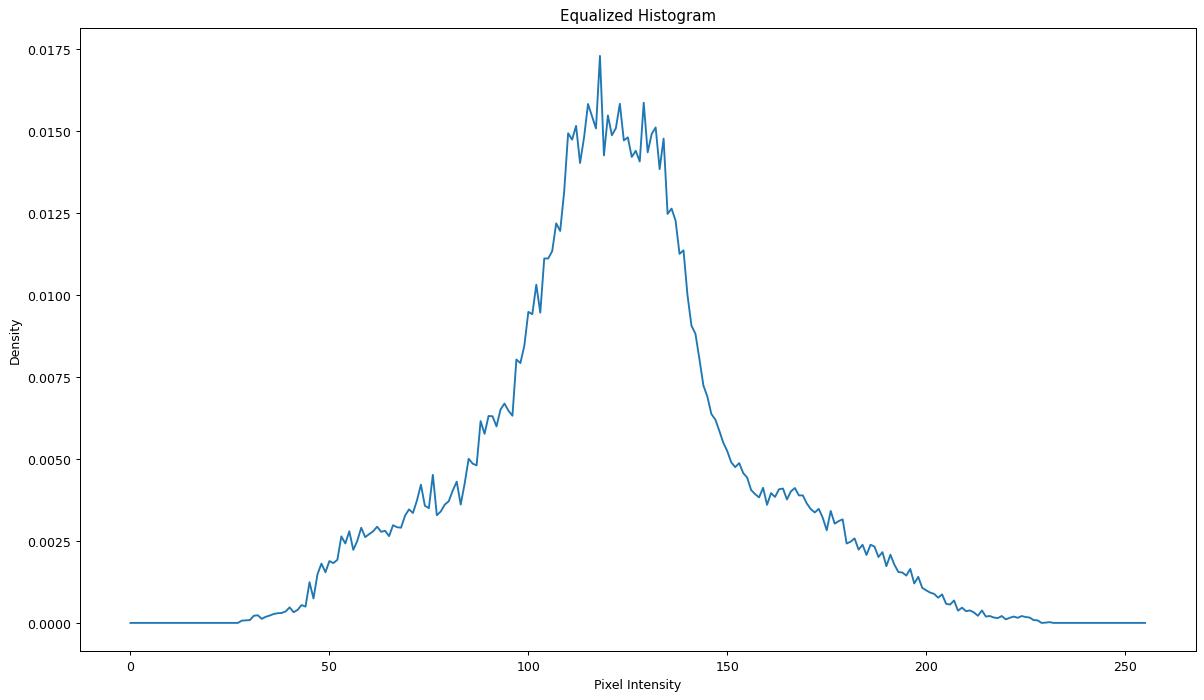

In [45]:
_ = histogram_plot(equalized, "Equalized Histogram")

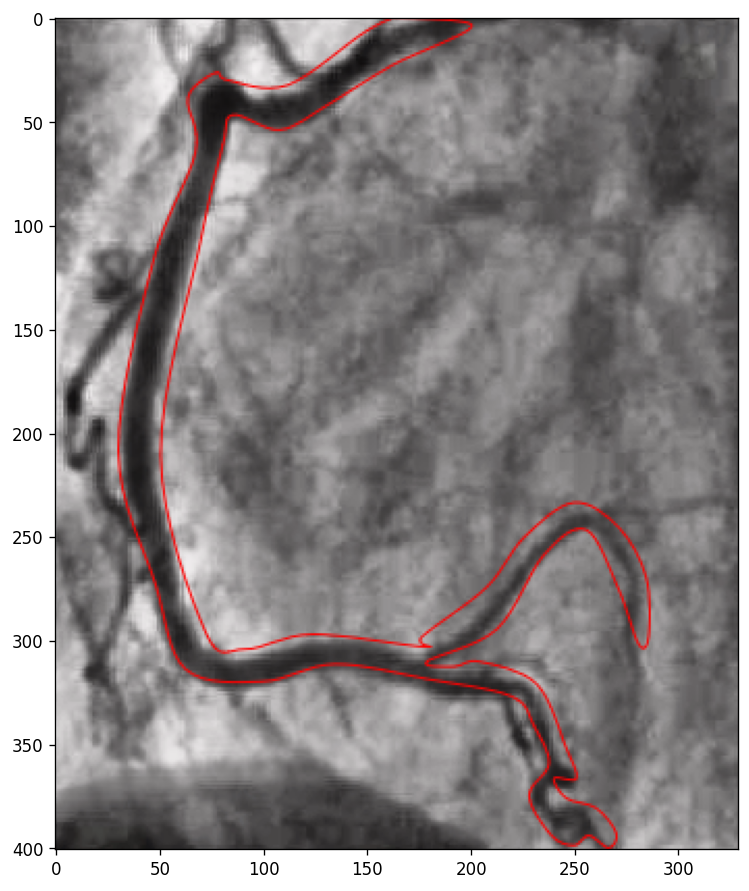

In [117]:
regions_img = cv2.cvtColor(
    cv2.imread('input/regions.png'),
    cv2.COLOR_RGB2BGR
)
plt.figure(figsize=(16,9), dpi=120)
_ = plt.imshow(regions_img)

In [35]:
def show_channels(img : NDArray, suptitle : str = None, subtitles : list = None, dpi : int = 90):
    fig = plt.figure(figsize=(16,9), dpi=dpi)
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        if subtitles:
            plt.gca().set_title(subtitles[i])
        plt.imshow(img[:,:,i], 'gray')
    if suptitle is not None:
        fig.suptitle(suptitle, size=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

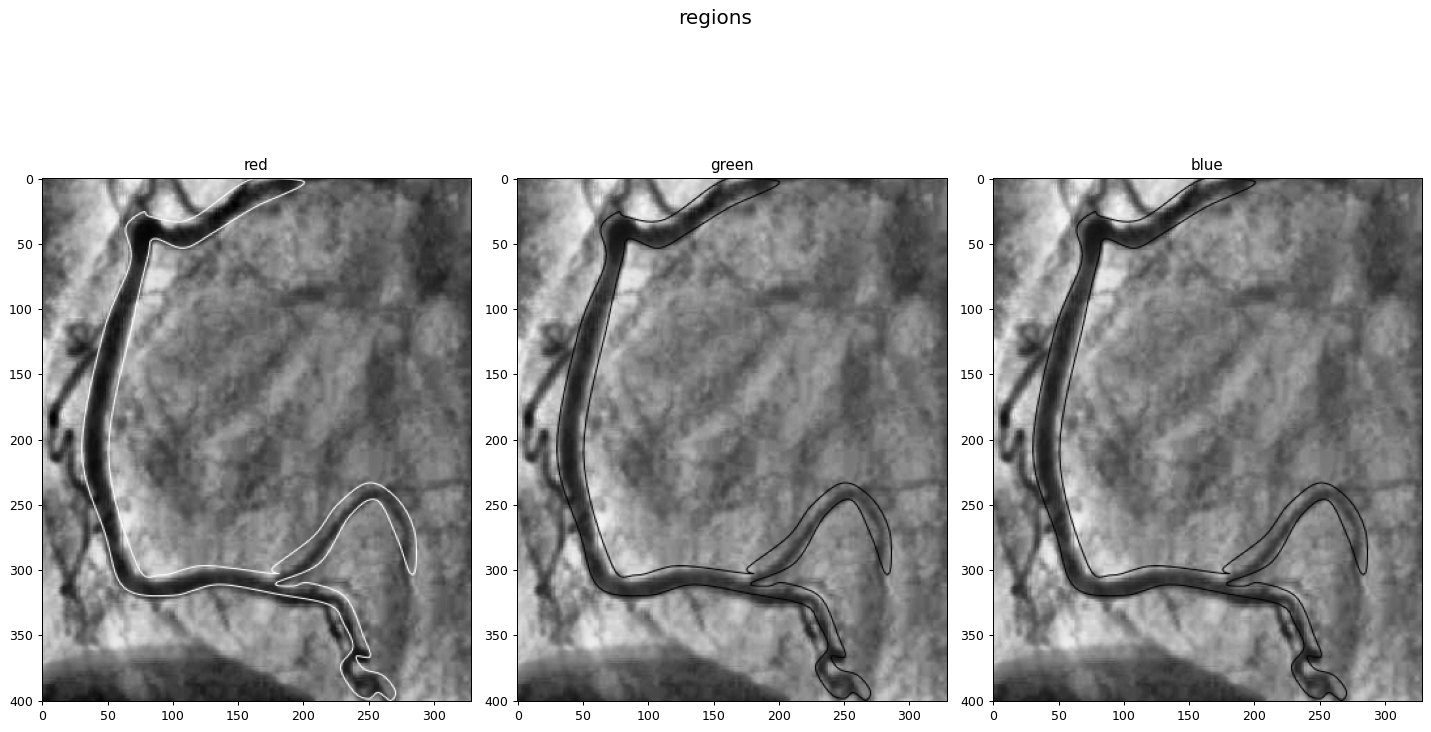

In [36]:
show_channels(regions_img, suptitle="regions", subtitles=['red','green','blue'])

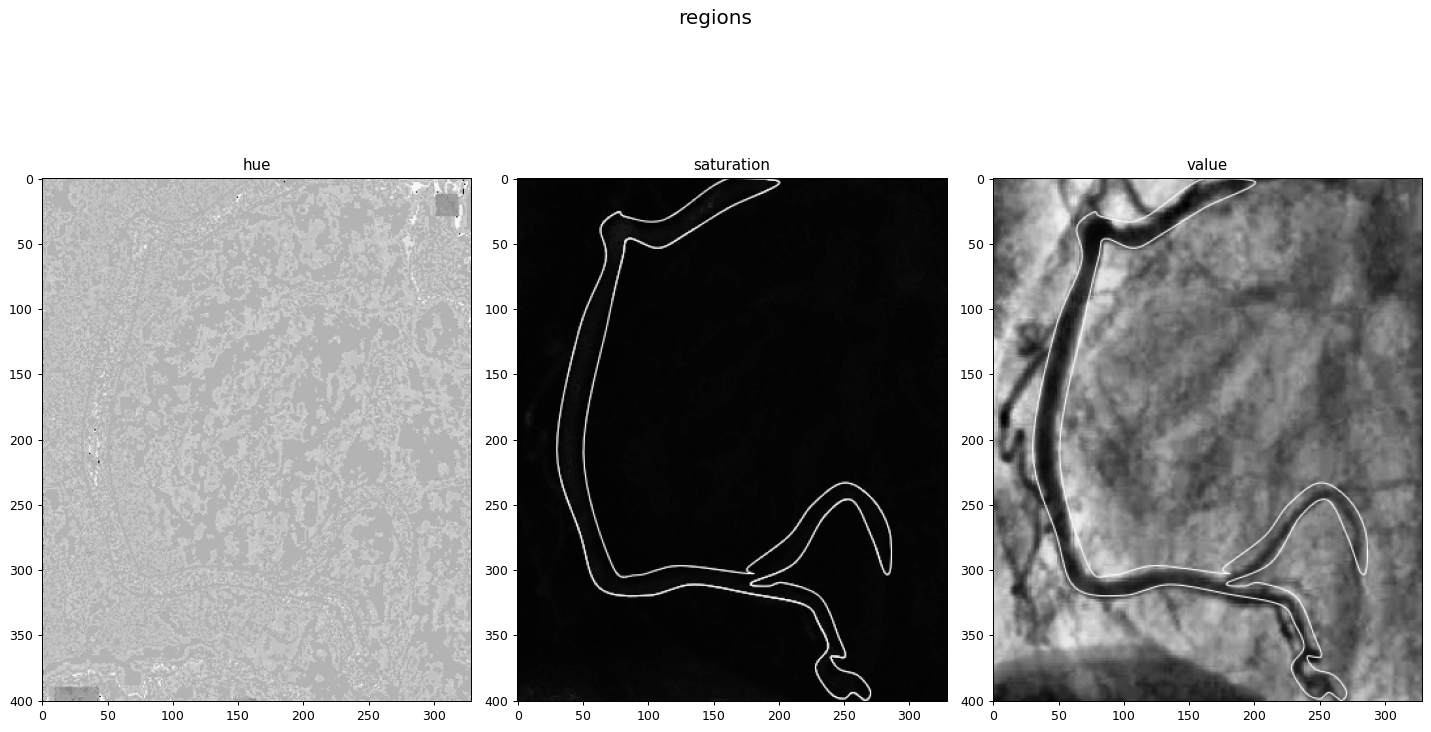

In [37]:
hsv = cv2.cvtColor(regions_img, cv2.COLOR_BGR2HSV)
show_channels(hsv, 'regions', subtitles=['hue', 'saturation', 'value'])

# Find the region boundary contour

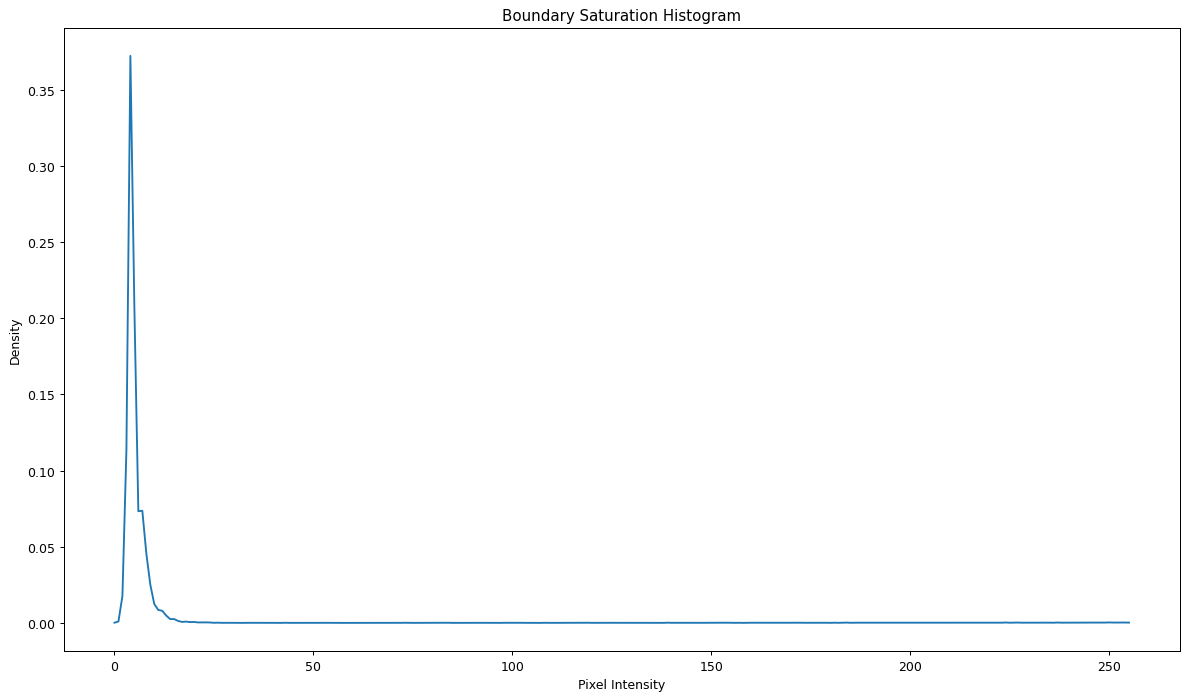

In [46]:
bins, hist = histogram_plot(hsv[:,:,1], "Boundary Saturation Histogram")

## Compute threshold level

In [62]:
percentile = 0.98
bin_index = np.argmax( np.cumsum(hist) >= percentile*np.sum(hist) )
print(f"Bin={bins[bin_index]} meets or exceens percentile={percentile}")

Bin=113.0 meets or exceens percentile=0.98


## Perform Threshold

Text(0.5, 1.0, 'Thresholded Saturation')

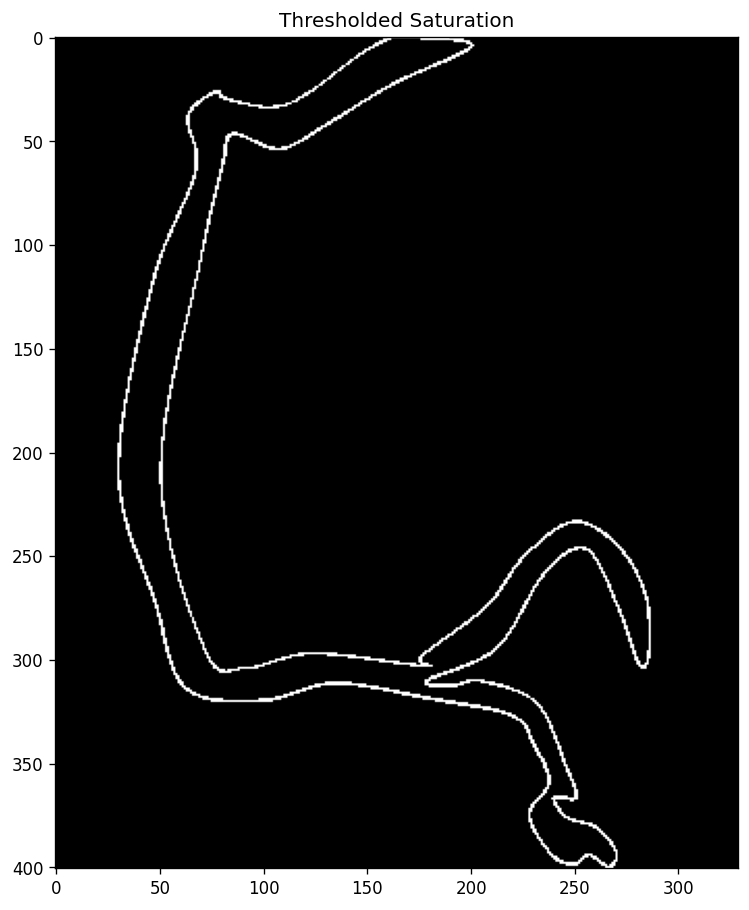

In [115]:
_, saturation_thresholded = cv2.threshold(hsv[:,:,1], bins[bin_index], 255, cv2.THRESH_BINARY)
plt.figure(figsize=(16,9), dpi=120)
plt.imshow(saturation_thresholded, 'grey')
plt.title("Thresholded Saturation")

## Mask for training

contour_img.shape=(400, 322, 3)


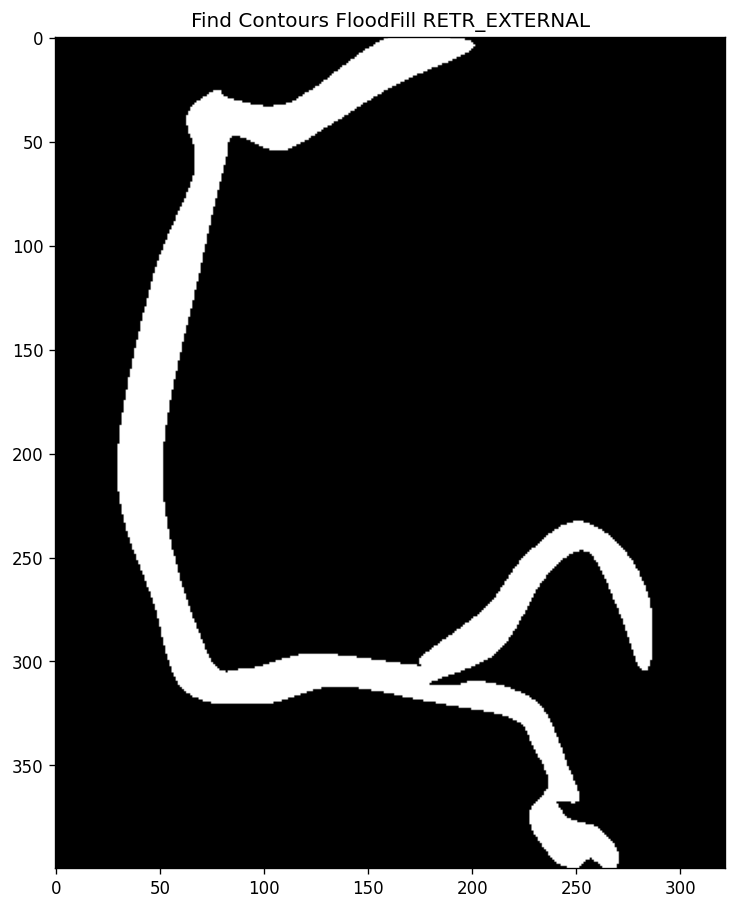

In [116]:
contours, _ = cv2.findContours(
    image=np.array(saturation_thresholded, dtype=np.uint8),
    mode=cv2.RETR_EXTERNAL,
    method=cv2.CHAIN_APPROX_SIMPLE
)
mask = np.zeros(img.shape, np.uint8)
contour_img = cv2.drawContours(
    image=mask, 
    contours=contours, 
    contourIdx=-1, 
    color=(255,255,255), 
    thickness=cv2.FILLED
)
plt.figure(figsize=(16,9), dpi=120)
_ = plt.imshow(contour_img, 'gray')
plt.title("Find Contours FloodFill RETR_EXTERNAL")
print(f"contour_img.shape={contour_img.shape}")

In [126]:
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

In [135]:
print(f"equalized.dtype={equalized.dtype} equalized.shape={equalized.shape} contour_img.dtype={contour_img.dtype} contour_img={contour_img.shape}")

equalized.dtype=uint8 equalized.shape=(400, 322) contour_img.dtype=uint8 contour_img=(400, 322, 3)


In [129]:
mask, bgdModel, fgdModel = cv2.grabCut(
    img=equalized,
    mask=contour_img[:,:,:],
    rect=None,
    bgdModel=bgdModel,
    fgdModel=fgdModel,
    iterCount=5,
    mode=cv2.GC_INIT_WITH_MASK
)

error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/grabcut.cpp:557: error: (-5:Bad argument) image must have CV_8UC3 type in function 'grabCut'
